# Проект - "Проверка гипотез по увеличению выручки в интернет-магазине — оценить результаты A/B теста".

## 1 Описание проекта.

**Общая информация о заказчике:** Крупного интернет-магазин, отдел маркетинга которого, подготовил список гипотез для увеличения выручки.

**Цель проекта** — Дать рекомендации для увеличения выручки интернет-магазина. 

**Задания:**
1. Приоритизировать гипотезы, 
2. Запустите A/B-тест,
3. Проанализировать результаты.

**План проекта:**
1. Описание проекта. 
2. Предобработка данных.
3. Приоритизация гипотез.
4. Анализ A/B-теста.
5. Общий вывод.

## 2 Предобработка данных

Перед тем как приступить к работе с гипотезами, сделаем предобработку данных.

In [1]:
# Импортируем необходимые библиотеки.

import pandas as pd
import numpy as np
import datetime as dt

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from datetime import date, time, timedelta

from tqdm import tqdm

### 2.1 Датафрейм data.

In [2]:
data = pd.read_csv('/datasets/hypothesis.csv') # Прочитаем файл с гипотезами и сохраним результат в датафрейме data
data # Выведем таблицу на экран

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Перед нами таблица со столбцами `Hypothesis`, `Reach`, `Impact`, `onfidence` и `Efforts`. Названия столбцов прописаны не в едином стиле - присутствует верхний и нижний регистр букв. Нужно преоброзовать назавания.

В столбце `Hypothesis` приписаны гипотезы с которомы мы будем работать, чтобы прочитать весь текст гипотезы уберем ограничения по числу символов в ширине столбцов с помощью функции set_option() и опции max_colwidth;

`Reach` — охват пользователей по 10-балльной шкале;

`Impact` — влияние на пользователей по 10-балльной шкале;

`Confidence` — уверенность в гипотезе по 10-балльной шкале;

`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

In [3]:
data.columns = data.columns.str.lower() # приведем названия столбцов к единому стилю 

In [4]:
pd.set_option('max_colwidth', None) # уберем ограничения по числу символов в ширине столбцов
data # Выведем таблицу на экран

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
data.info() # выведем основную информацию о датафрейме с помощью метода info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Названия столбцов прописаны в едином стиле - в нижнем регистре букв. Столбец `hypothesis` имеет тип **object**, остальные - числовой.

In [6]:
print(data.duplicated().sum()) # выведем колличество дубликатов 

0


В датафрейме `data` пропусков и дубликтов нет.Рассмотрим другие таблицы. 

### 2.2 Датафрейм orders.

In [7]:
orders = pd.read_csv('/datasets/orders.csv') # Прочитаем файл с результати и сохраним результат в датафрейме orders
orders.head(10) # Выведем на экран 10 строк таблицы orders.

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Перед нами таблица со столбцами `transactionId`, `visitorId`, `date`, `revenue`, `group`. Названия прописаны в нижнем регистре, пропишем столбцы `transactionId` и `visitorId`	змеиным формате - `transaction_id` и `visitor_id`	 соотвественно. 

`transaction_id` (`transactionId`) — идентификатор заказа;

`visitor_id` (`visitorId`) — идентификатор пользователя, совершившего заказ;

`date` — дата, когда был совершён заказ;

`revenue` — выручка заказа;

`group` — группа A/B-теста, в которую попал заказ.

In [8]:
# переименуем столбцы transactionId и visitorId на transaction_id и visitor_id 
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [9]:
orders.info() # выведем основную информацию о датафрейме с помощью метода info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Столбцы `date` и `group` имеют тип  **object**, остальные - числовой. Столбец с датой нужно перевести в тип - **datetime**.

In [10]:
orders['date'] = pd.to_datetime(orders['date']) # преобразуем тип данных для столбцов с датой и временем

In [11]:
round((orders.isna().mean()*100),2) # найдем процент пропущегный значений в каждом столбце

transaction_id    0.0
visitor_id        0.0
date              0.0
revenue           0.0
group             0.0
dtype: float64

In [12]:
print(orders.duplicated().sum()) # выведем колличество дубликатов 

0


Столбцы в таблице `orders` прописаны в едином стиле, пропусков и дубликатов нет. 

In [13]:
orders['group'].unique() # выведем уникальные значения для столбца group

array(['B', 'A'], dtype=object)

Столбец `group` имеет два уникальных значения "А" и "В", значит в А/В тесте у нас 2 группы. 

In [14]:
orders['date'].max() # найдем самую позднюю дату в таблице

Timestamp('2019-08-31 00:00:00')

In [15]:
orders['date'].min() # найдем самую раннюю дату в таблице

Timestamp('2019-08-01 00:00:00')

Дата начала теста - это самая ранняя дата в таблице - `2019-08-01`, конец теста - самая поздняя дата - `2019-08-31`. 

In [16]:
# найдем пользователей, которые попали в обе группы
np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [17]:
# сохраним пользователей, которые попали в обе группы в список list1
list1 = np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())
  
# удалим из таблицы пользователей, которые попали в обе группы
orders = orders[orders.visitor_id.isin(list1) == False]

In [18]:
# проверим
np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())

array([], dtype=int64)

### 2.3 Датафрейм visitors.

In [19]:
visitors = pd.read_csv('/datasets/visitors.csv') # Прочитаем файл с результати и сохраним результат в датафрейме visitors
visitors.head(10) # Выведем на экран 10 строк таблицы visitors.

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Перед нами таблица со столбцами `date`, `group`, `visitors`. Названия прописаны в едином стиле.

`date` — дата;

`group` — группа A/B-теста;

`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [20]:
visitors.info() # выведем основную информацию о датафрейме с помощью метода info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Столбцы `date` и `group` имеют тип **object**, `visitors` - числовой. Столбец с датой нужно перевести в тип - **datetime**.

In [21]:
visitors['date'] = pd.to_datetime(visitors['date']) # преобразуем тип данных для столбцов с датой и временем

In [22]:
round((visitors.isna().mean()*100),2) # найдем процент пропущегный значений в каждом столбце

date        0.0
group       0.0
visitors    0.0
dtype: float64

In [23]:
print(visitors.duplicated().sum()) # выведем колличество дубликатов 

0


Столбцы в таблице `visitors` прописаны в едином стиле, пропусков и дубликатов нет.

In [24]:
visitors['group'].unique() # выведем уникальные значения для столбца group

array(['A', 'B'], dtype=object)

Столбец `group` имеет два уникальных значения "А" и "В", значит в А/В тесте у нас 2 группы.

In [25]:
visitors['date'].max() # найдем самую позднюю дату в таблице

Timestamp('2019-08-31 00:00:00')

In [26]:
visitors['date'].min() # найдем самую ранюю дату в таблице

Timestamp('2019-08-01 00:00:00')

Дата начала теста - это самая ранняя дата - `2019-08-01`, конец теста - самая поздняя дата в таблице - `2019-08-31`. Что совподает с таблицей `orders`.

**Вывод:** Таблицы пропусков и дубликтов не имеют, названия столбцов приведены в единый стиль - нижний регистр.

Солбцы имеют разные типы данных, столбцы с датой приведены в тип для работы с датой и временем. 

В таблице представлены 2 группы для А/В-теста. Пользователей которые вошли в обе группы - удалили. 

Дата начала теста - `2019-08-01`, конец теста - `2019-08-31`.



## 3 Приоритизация гипотез. 

### 3.1 Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [27]:
data['ICE'] = round((data['impact'] * data['confidence']) / data['efforts'], 2) # добавим новый столбец ICE 
data.loc[:,['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending=False) # Выведем гипотезы и ICE отсортировав по ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Используя метод ICE мы видим, что гипотезы номер `8`, `0` и `7` наиболее приоритетны.

### 3.2 Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [28]:
data['RICE'] = (data['reach'] * data['impact'] * data['confidence']) / data['efforts'] # добавим новый столбец RICE 
data.loc[:,['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending=False) # Выведем гипотезы и ICE отсортировав по RICE

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Используя метод RICE мы видим, что гипотезы номер `7`, `2` и `0` наиболее приоритетны.

In [29]:
data # выведем всю таблицу с новыми столбцами ICE и RICE.

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


### Вывод. 

Используя метод ICE мы видим, что гипотезы номер `8`, `0` и `7` наиболее приоритетны.
- `8. Запустить акцию, дающую скидку на товар в день рождения` - 16.20,
- `0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`	- 13.33,
- `7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` - 11.20.

А используя метод RICE наиболее приоритетны гипотезы номер `7`, `2` и `0`.

При применении RICE вместо ICE, на первое место вышла гипотеза `7`, а также в тройку попала гипотеза `2` (на втрое место). 
- `7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` - 112.0,
- `2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа` - 56.0,
- `0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей` - 40.0.

Причины изменений можно объяснить тем, что мы добавили значение Reach — охват пользователей по 10-балльной шкале, соотвественно учли условие, как гипотеза затронет  пользователей. Для гипотезы `"7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"`, значение Reach равно 10, т.е. гипотеза затрагивает всех пользователей соответвенно она вышла первой в приоритете. По этой же причине гипотеза `"8. Запустить акцию, дающую скидку на товар в день рождения"` опустилась на пятую позицую, у нее значение Reach равно всего лишь 1. 

Также для большинства пользоватлей акутальна гипотеза `"2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"` Reach равно 8. 

Гипотеза `"0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"` попала в топ три по приоритету, т.к. значение Impact — влияние на пользователей по 10-балльной шкале максимальна и равна 10. 

## 4 Анализ A/B-теста

### 4.1 График кумулятивной выручки по группам.

Построем график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [30]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [31]:
cumulativeData['date'].max() # выведем на экрон самую позднюю дату из таблицы 

Timestamp('2019-08-31 00:00:00')

In [32]:
cumulativeData['date'].min() # выведем на экрон самую раннюю дату из таблицы 

Timestamp('2019-08-01 00:00:00')

Значения самой ранней и поздней дат совподают с датой начала теста - `2019-08-01`, и с датой конца теста - `2019-08-31`.

Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

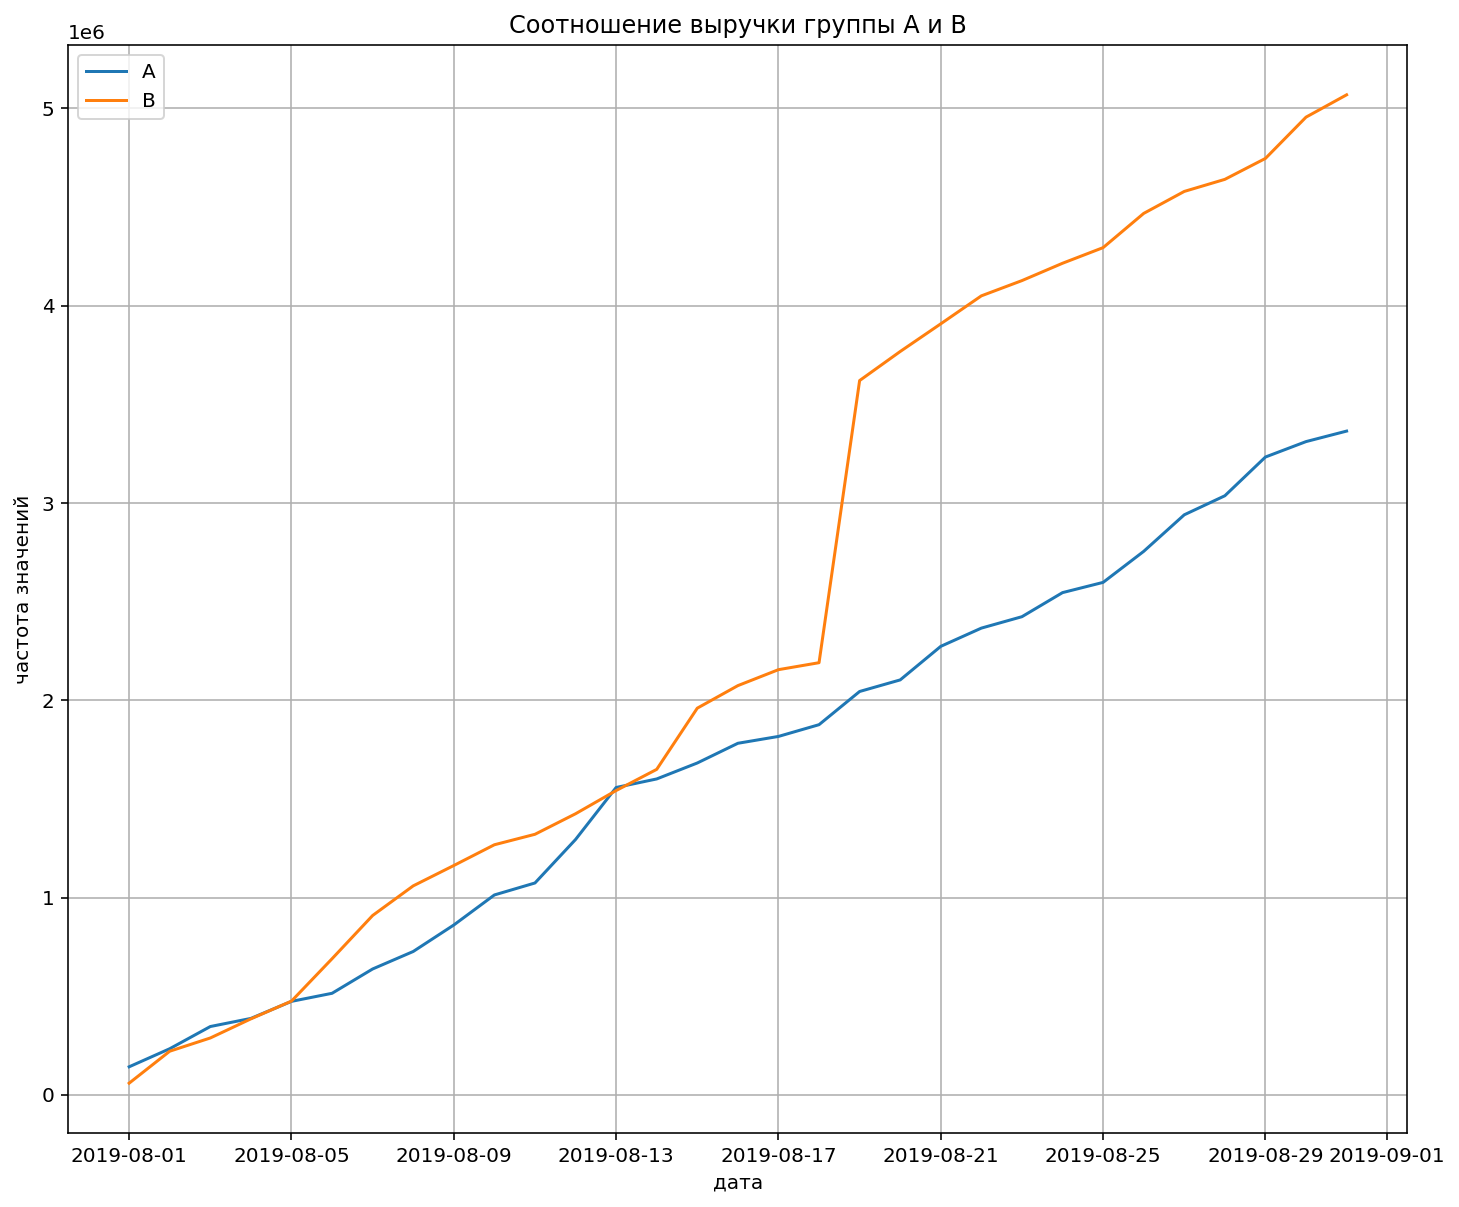

In [33]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() # разместим легенду на график
plt.title('Соотношение выручки группы А и В', fontsize = 12) # разместим название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

Выручка почти равномерно увеличивается в течение всего теста. Однако графики выручки группы В резко возрастает в перио с 17 по 21 число. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### 4.2 График кумулятивного среднего чека по группам.
Построем график кумулятивного среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов. Сделаем выводы и предположения.

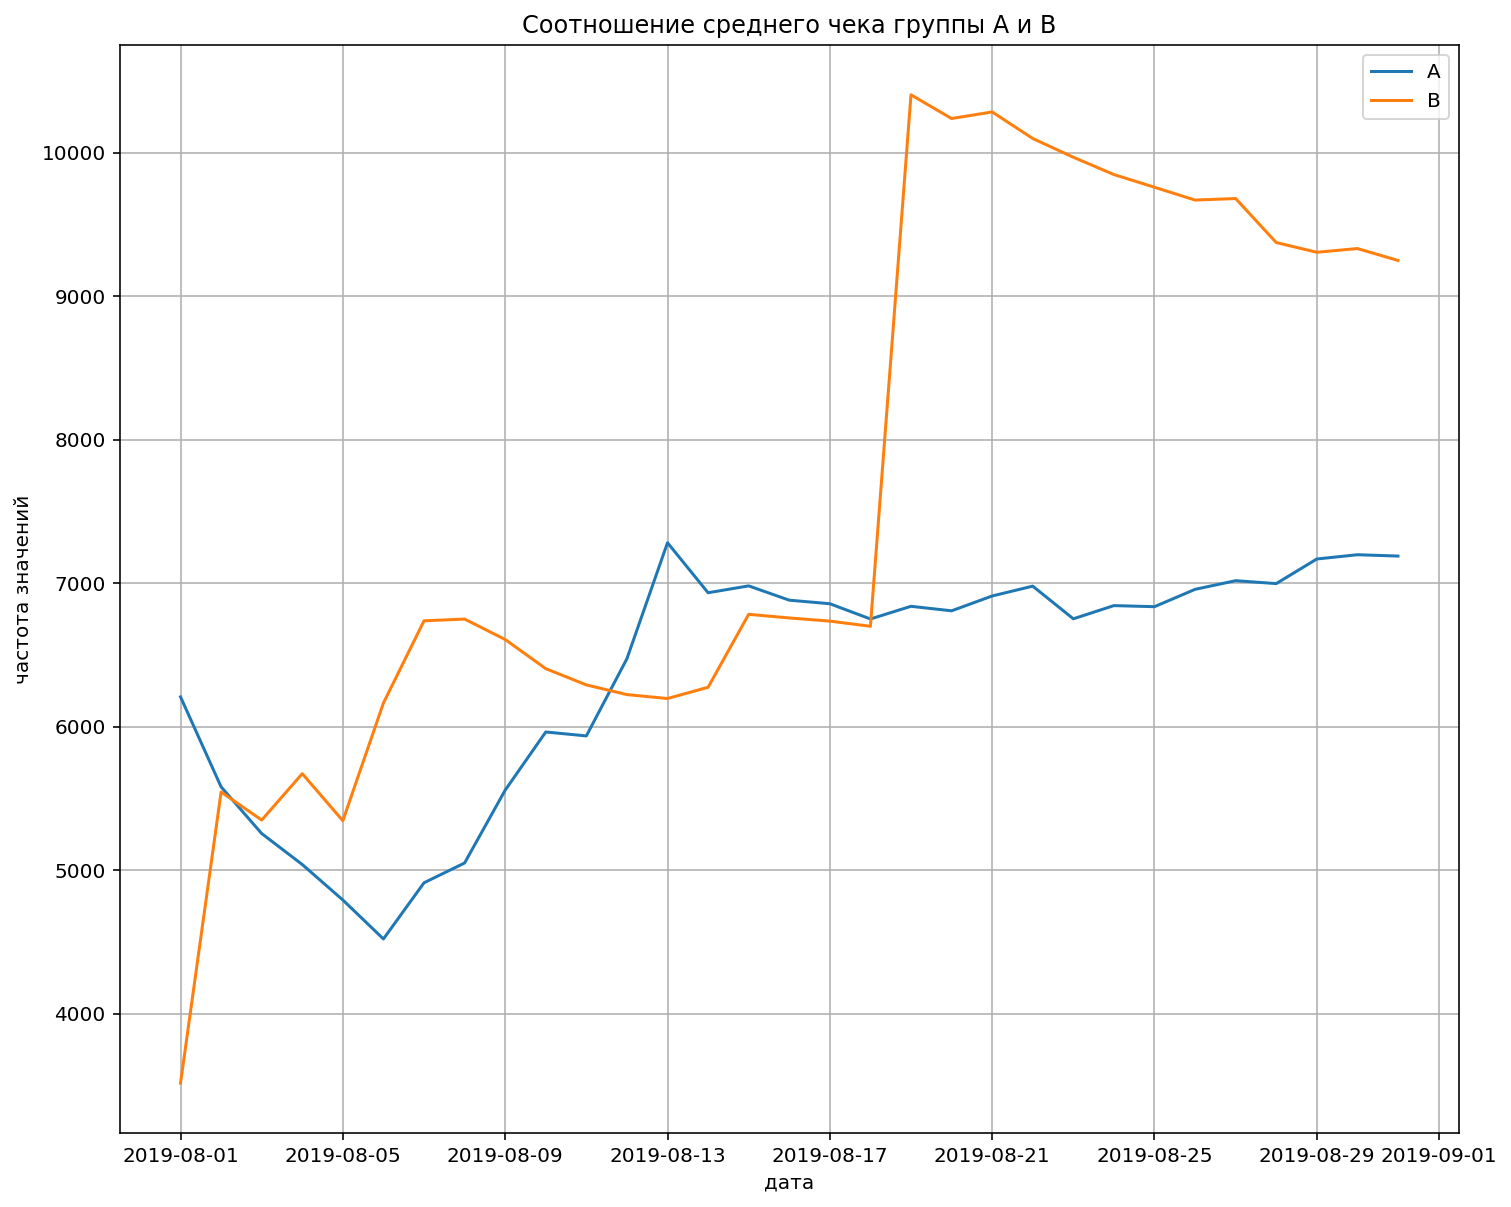

In [34]:
plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend() # разместим легенду на график
plt.title('Соотношение среднего чека группы А и В', fontsize = 12) # разместим название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Возможно, в группу B в период с 17 по 21 число попали крупные заказы (резкий всплеск на графике). Тогда нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. На дистанции значение должны устаканиться, примерно это и показывает группа A. На группу B же сильно повлиял скачок.

### 4.3 График относительного изменения кумулятивного среднего чека группы B к группе A.

Построем график относительного изменения кумулятивного среднего чека группы B к группе A.  Добавим горизонтальную ось методом axhline() (от англ. horizontal line across the axis*, «горизонтальная линия поперек оси»). Сделаем выводы и предположения.

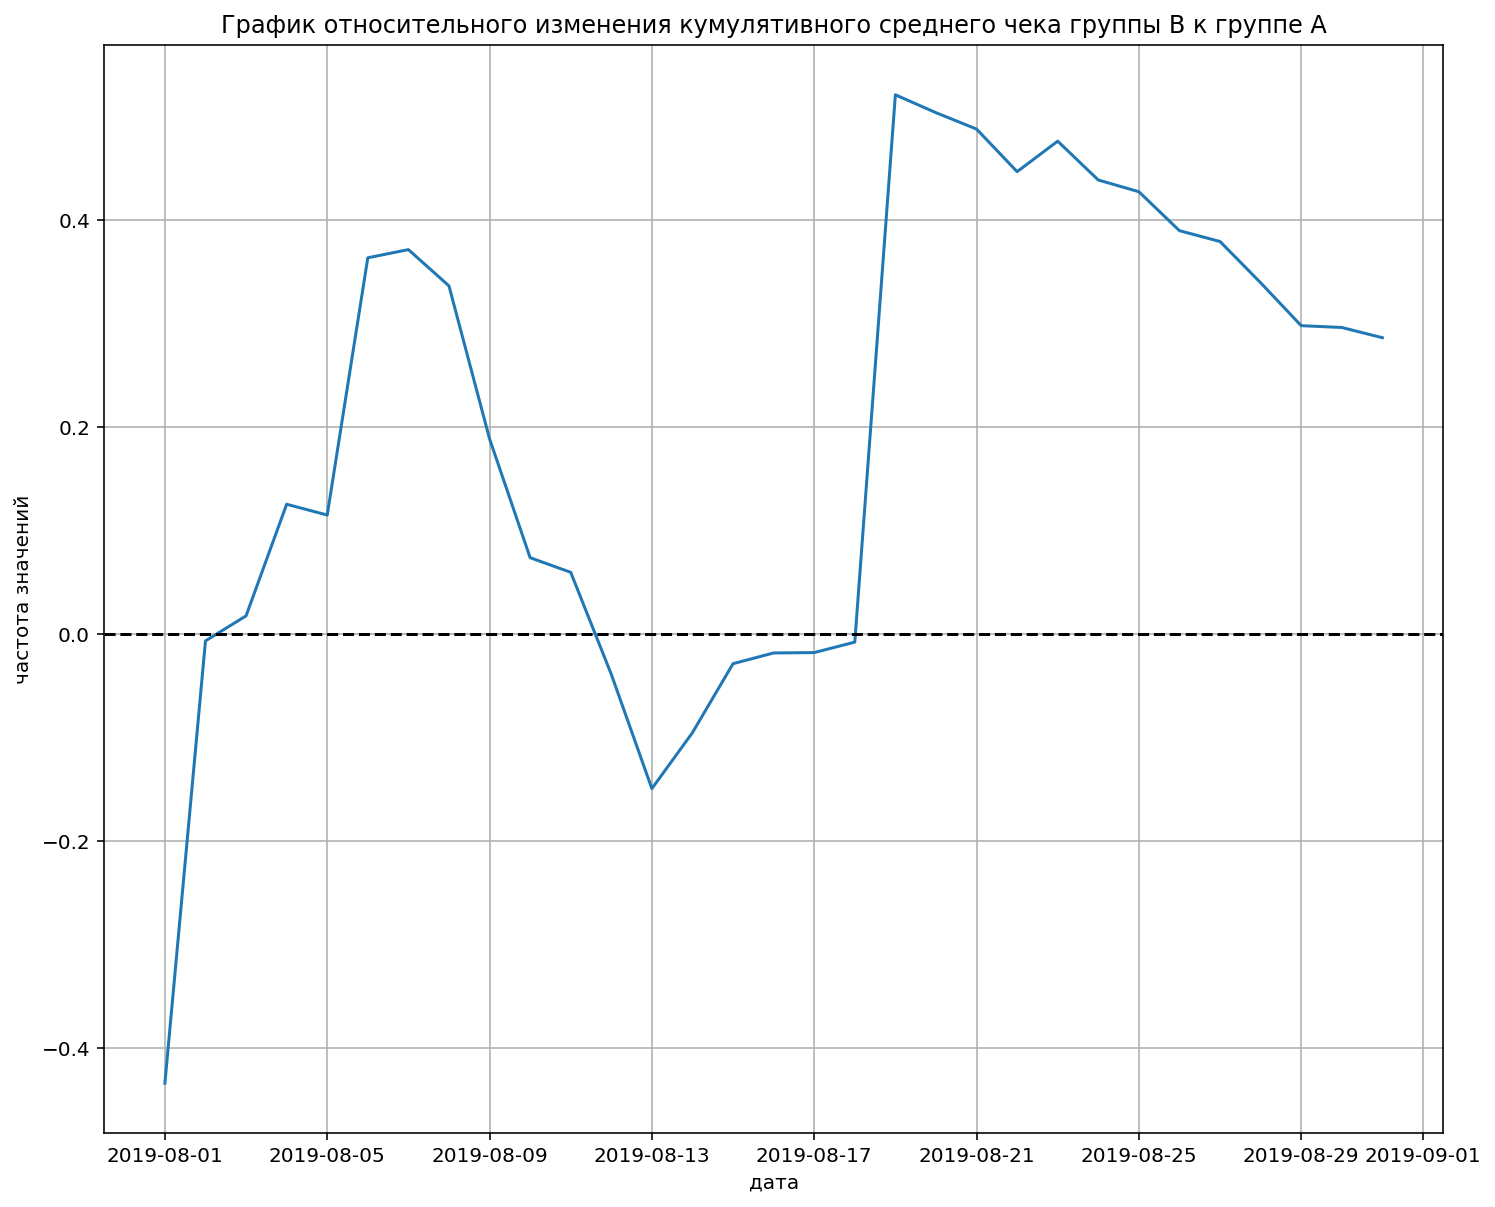

In [35]:
plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 12) # название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

В нескольких точках график различия между сегментами резко «скачет». Вероятно в период с 17 по 21 августа спрятались крупные заказы и выбросы.

### 4.4 График кумулятивного среднего количества заказов на посетителя по группам. 

Построем график кумулятивного среднего количества заказов на посетителя по группам - разделим среднего количества заказов на кумулятивное число посетителей по группам (найдем кумулятивную конверсию). Сделаем выводы и предположения.

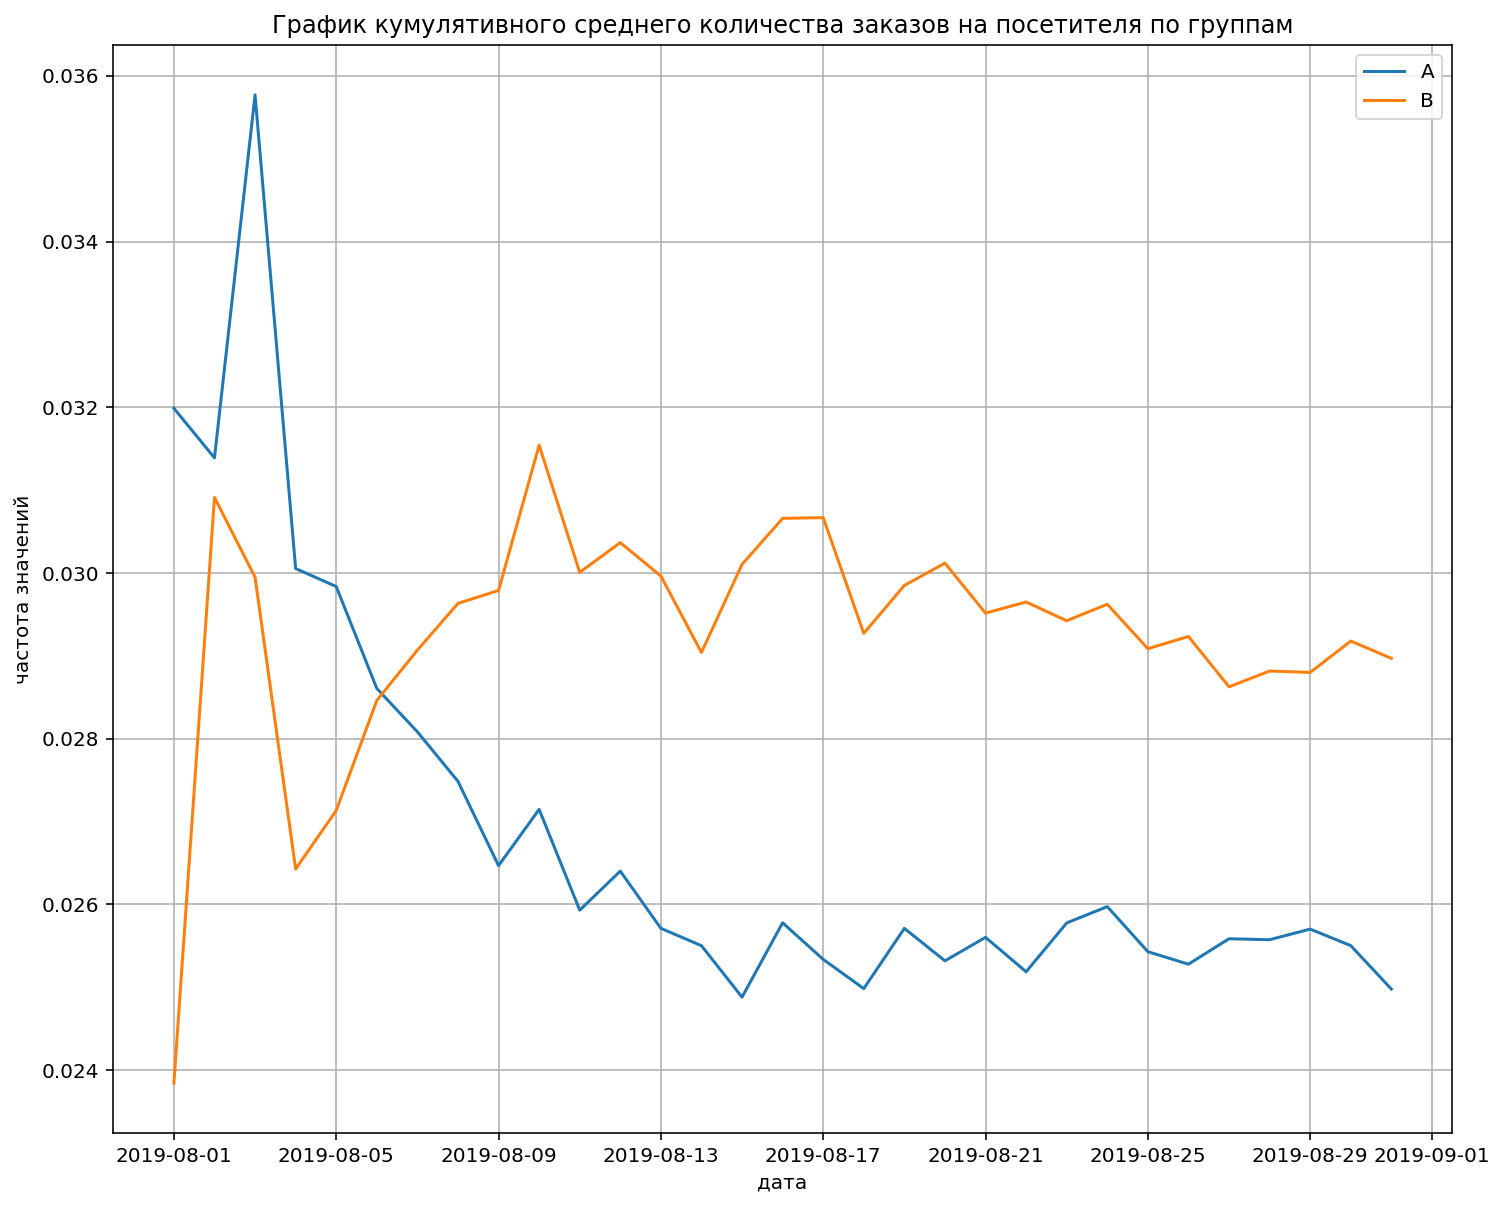

In [36]:
plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend() # разместим легенду на график
plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize = 12) # название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график


Группы колебались около одного значения, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

### 4.5 График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

Построем график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.

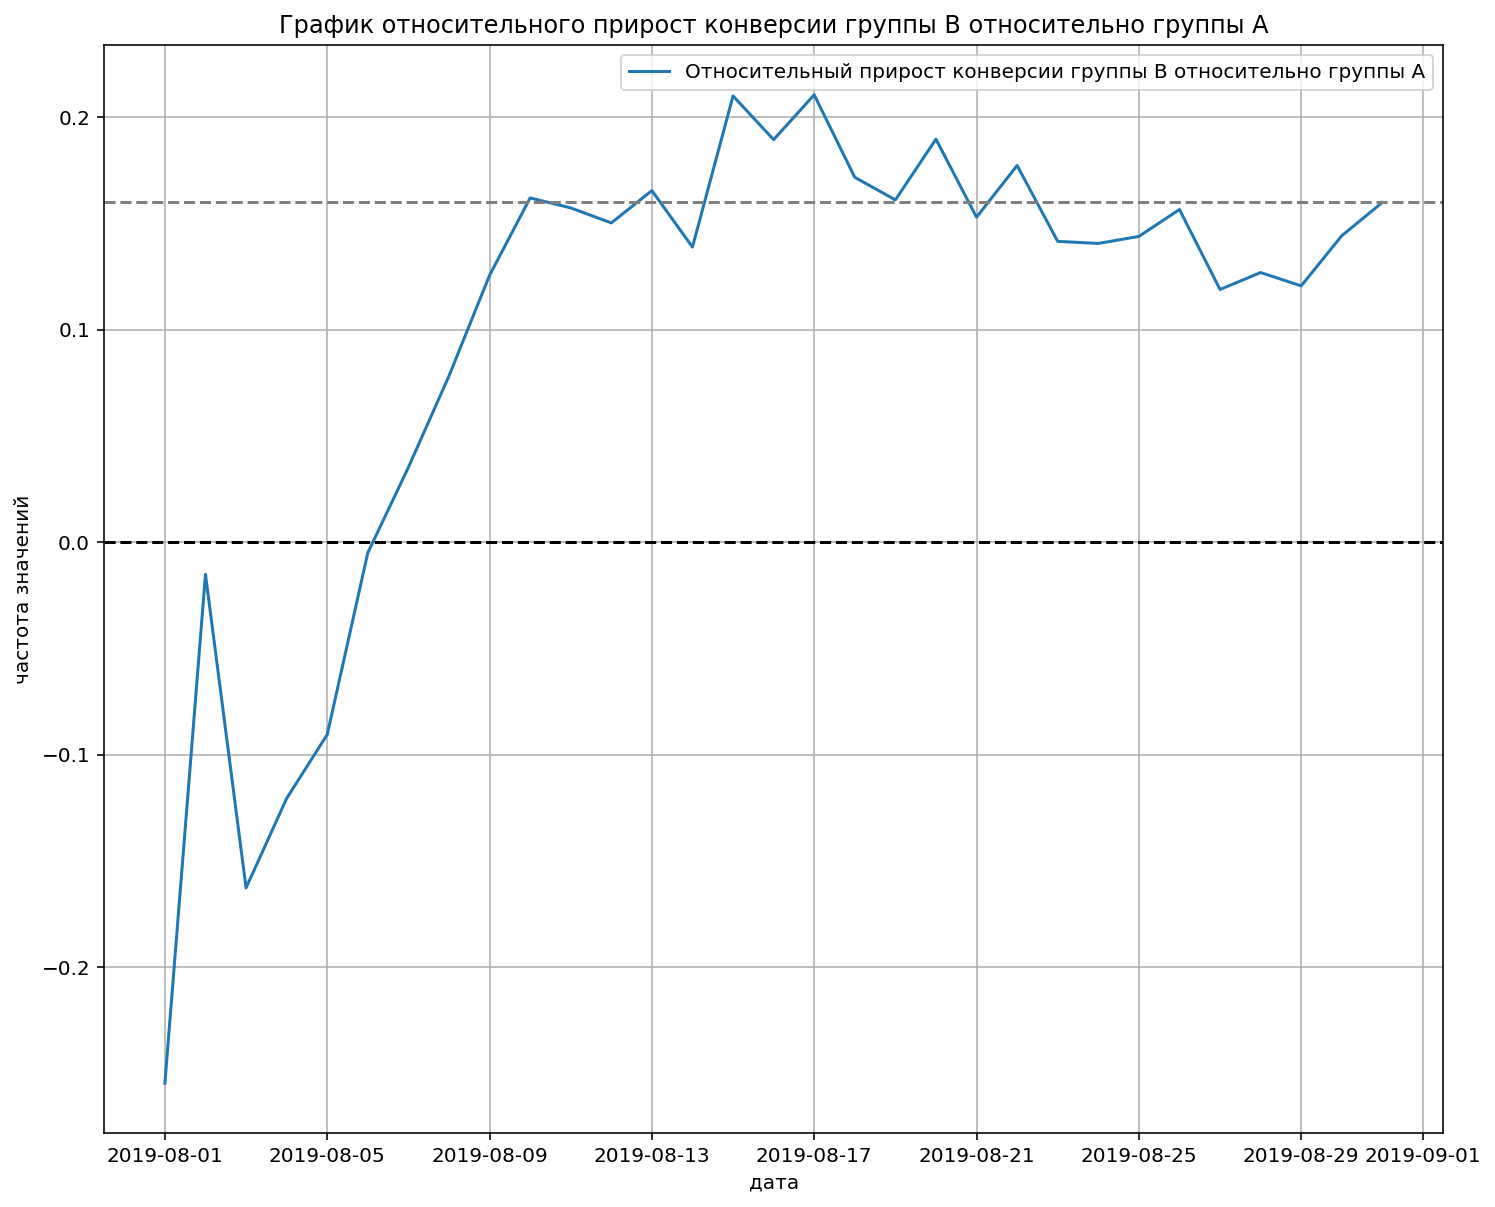

In [37]:
plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')

plt.legend() # разместим легенду на график
plt.title('График относительного прирост конверсии группы B относительно группы A', fontsize = 12) # название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

В начале теста группа B выигрывала у группы A, далее резкое падение, но затем группа B стабильно и постепенно растёт с небольшими колебаниями. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

### 4.6 Точечный график количества заказов по пользователям. 

Построем точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [38]:
orders.head(5) # выведем первые 5 строк таблицы с котрой будем работать - orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [39]:
# оставим в новой таблице ordersByUsers даннные из orders - идентификаторы пользователей и заказов, сгруппировав по visitor_id 
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['visitor_id', 'orders'] # зададим названия для новой таблицы
ordersByUsers.sort_values(by='orders', ascending=False).head(10) # выведем первые 10 строк, отсортировав по заказам

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


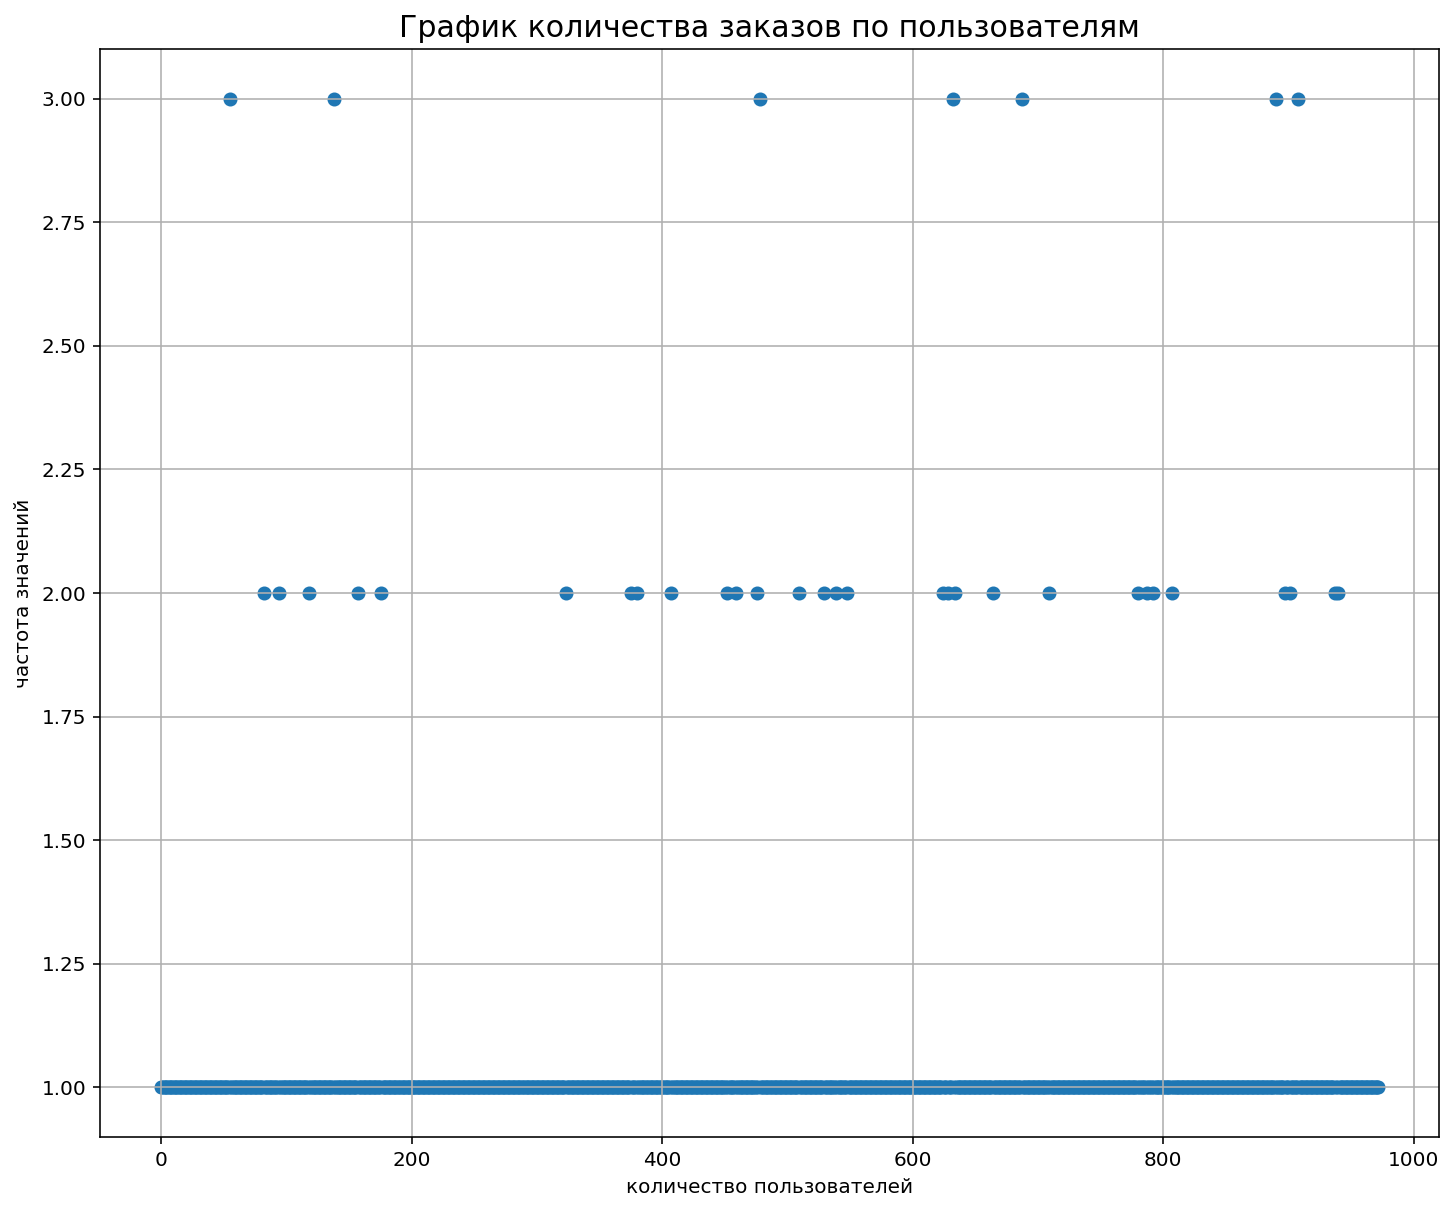

In [40]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям', fontsize = 15) # название графика
plt.xlabel('количество пользователей') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

Всё, как предполагали: есть немного дорогих заказов. По графику видно, что большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна. Их точная доля не ясна. Непонятно, считать их аномалиями или нет. Принято отсеивать от 1% до 5% наблюдений с крайними значениями. Посчитаем выборочные перцентили количества заказов на одного пользователя.

### 4.7 95-й и 99-й перцентили количества заказов на пользователя. 

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [41]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше чем 2 заказа. Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. Удалим такие строки.

###  4.8 Точечный график стоимостей заказов. 

Построем точечный график стоимостей заказов. Сделаем выводы и предположения.

In [42]:
orders.sort_values(by='revenue', ascending=False).head(10) # выведем первые 10 строк таблицы с котрой будем работать - orders

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


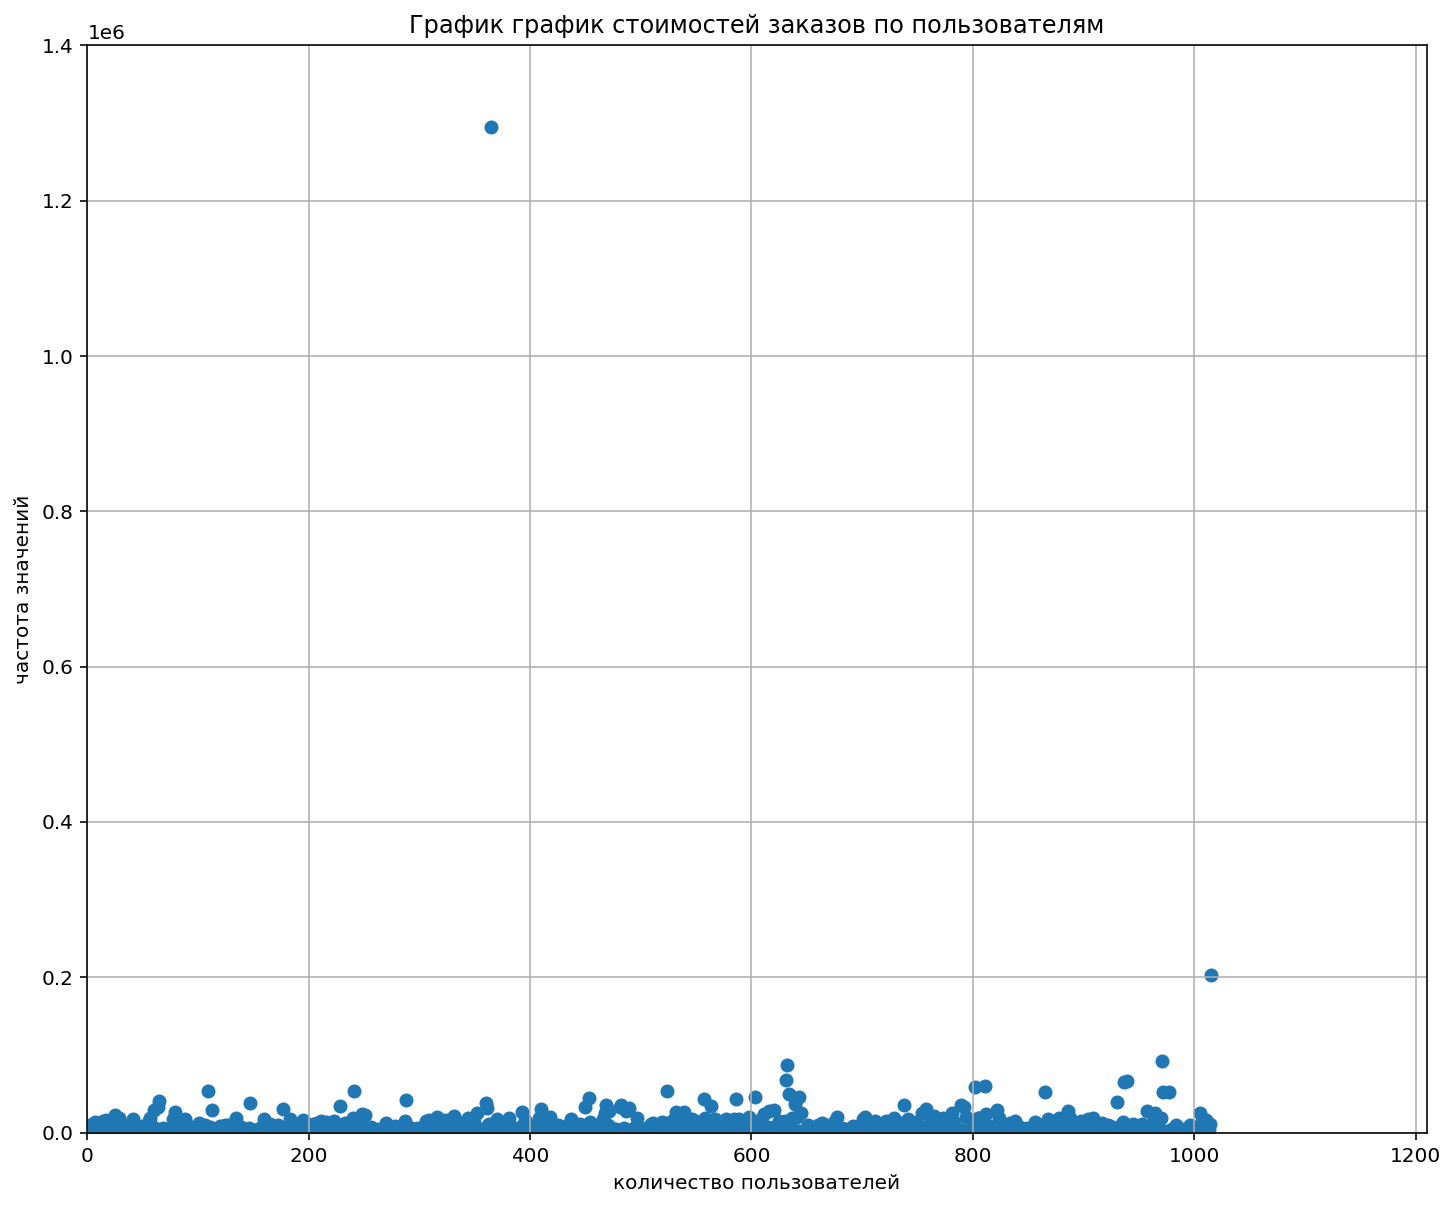

In [43]:
x_values = pd.Series(range(0,len(orders)))

plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков
plt.scatter(x_values, orders['revenue']) 
plt.title('График график стоимостей заказов по пользователям', fontsize = 12) # название графика
plt.xlabel('количество пользователей') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.axis([0, 1210, 0, 1400000])
plt.grid() # добавим сетку на график
plt.show(); # выведем график

Всё, как предполагали: есть аномально дорогие заказы. 1 294 500, вот почему так резко поднялся средний чек. По графику нельзя выбрать границу аномальных заказов. Обратимся к процентилям. 

### 4.9 95-й и 99-й перцентили стоимости заказов. 

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [44]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей.

### 4.10 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 

- Нулевая: различий в среднем количестве заказов между группами нет. 
- Альтернативная: различия в среднем между группами есть.

Значение `alpha` возьмем 0,05. Будем использовать метод проверка статистических гипотез.

Начнём с подготовки данных.

In [45]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5) # выведем первые 5 строк объедененной таблицы

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Создадим переменные ordersByUsersA и ordersByUsersB со столбцами 'visitor_id', 'orders'. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [46]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [47]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0, 
            index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders'
        )
    ],
    axis=0
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0, 
            index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders'
        )
    ],
    axis=0
)

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

Напомним, что в sampleA сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). Аналогично найдём среднее группы B: SampleB.mean().

Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1. Округлим до трёх знаков после запятой.

In [48]:
print('p-значение:',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])) 

print('Относительный прирост конверсии группы В к конверсии группы А: '"{0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение: 0.011
Относительный прирост среднего группы В к конверсии группы А: 16.0%


**Вывод:** Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. 

Анализ "сырых данных" сообщает, что в среднем колличестве заказов между группами есть статистически значимые различия.
Относительный прирост конверсии группы В к конверсии группы А равен 16%.

Осталось сравнить средние чеки по "сырым данным", а затем обе метрики еще раз после удаления выбрасов. 

### 4.11 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 
- Нулевая гипотеза: различий в среднем чеке между группами нет. 
- Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
А ещё найдём относительные различия в среднем чеке между группами:

In [49]:
print('p-значение:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между сегментами','{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.829
Относительное различие среднего чека между сегментами 28.7%


**Вывод:** P-value значительно больше 0.05. Значит, не отвергаем нулевую гипотезу -  различий в среднем чеке между группами нет. 

Относительное различие среднего чека между сегментами 28,7%.

### 4.12 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

Приступаем к подготовке очищенных от аномалий данных.

Напомним, что 95-й и 99-й перцентили средних чеков равны 28 000 и  58 233 рублей. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [50]:
# Сделаем срезы пользователей с числом заказов больше двух
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['visitor_id'],
    ],
    axis=0,
)

# Сделаем срезы пользователей совершивших заказы дороже 28 000
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']

# Объединим аномальных пользователей в таблице abnormalUsers, удалим дубликаты, отсортируем по возрастанию
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5) # Выведем первые 5 строк новой таблицы 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

In [51]:
abnormalUsers.shape[0] # Узнаем, сколько всего аномальных пользователей атрибутом shape

86

Всего 86 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Подготовим выборки количества заказов по пользователям по группам теста:

In [52]:
# В переменные sampleAFiltered и sampleBFiltered, сохраним очищенные данные о заказах — не включая аномальных пользователей.

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы.

- Нулевая: различий в среднем количестве заказов между группами нет.
- Альтернативная: различия в среднем между группами есть.

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [62]:
# Выведем p-value для сравнения среднего между очищенными группами. Округлим p-value до 3х знаков после запятой
print('p-значение:''{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

# Выведем относительный прирост среднего очищенной группы B, округлив до трёх знаков после запятой
print('Относительный прирост конверсии группы В к конверсии группы А: ''{0:.1%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-значение:0.016
Относительный прирост конверсии группы В к конверсии группы А: 17.4%


**Вывод:** P-value значительно меньше 0.05. Значит, есть причины отвергнуть нулевую гипотезу и считать, что в среднем количестве заказов на посетителя между группами по «очищенным» данным есть различия.  Конверсия группы В больше группы А на 17,4 %.

### 4.13 Статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

In [54]:
# Выведем p-value для сравнения средних чеков между очищенными группами. Округлим p-value до трёх знаков после запятой.
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

# Выведем относительный прирост среднего чека очищенной группы B, округлив до трёх знаков после запятой
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.727
-0.034


Сформулируем Нулевую гипотезу - Размер среднего чека в группах А и Б одинаковые. 

Альтернативная гипотеза - Размер среднего чека в группах А и Б различны. 

**Вывод:** P-value = 0.738 значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать нет - в среднем чеке заказа между группами по «очищенным» данным различий нет.

Средний чек группы А незначительно выше (на 2%) среднего чека группы В.

### 4.14 Принятие решения по результатам теста.

По результатам теста нам нужно примите решение. Какие варианты решений у нас есть: 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

Какие выводы по тесту можем сделать?

Имеющиеся факты:

- Анализ "сырых данных" сообщает, что в среднем колличестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равен 13,8%;

- По "сырым данным" - различий в среднем чеке между группами нет. Относительное различие среднего чека между сегментами 25,9%;

- В среднем количестве заказов на посетителя между группами по «очищенным» данным есть различия;

- В среднем чеке заказа между группами по «очищенным» данным различий нет;

- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и и постепенно растёт с небольшими колебаниями;

- График различия среднего чека говорит о том, что результаты группы B лучше группы А на 25%.

Получается, что:

- Есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.

Для принятия решения построим график различия среднего чека без аномалий:


In [55]:
orders_f = orders.copy() # сделаем копию таблицы orders
orders_f = orders_f.query('revenue < 28000') # оставим в новой таблицы заказы менее 28 000

In [56]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders_f[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders_f[np.logical_and(orders_f['date'] <= x['date'], orders_f['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,21,17,84790,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,40,34,176392,1338
3,2019-08-02,B,38,37,152992,1294
4,2019-08-03,A,64,58,288865,1845


In [57]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

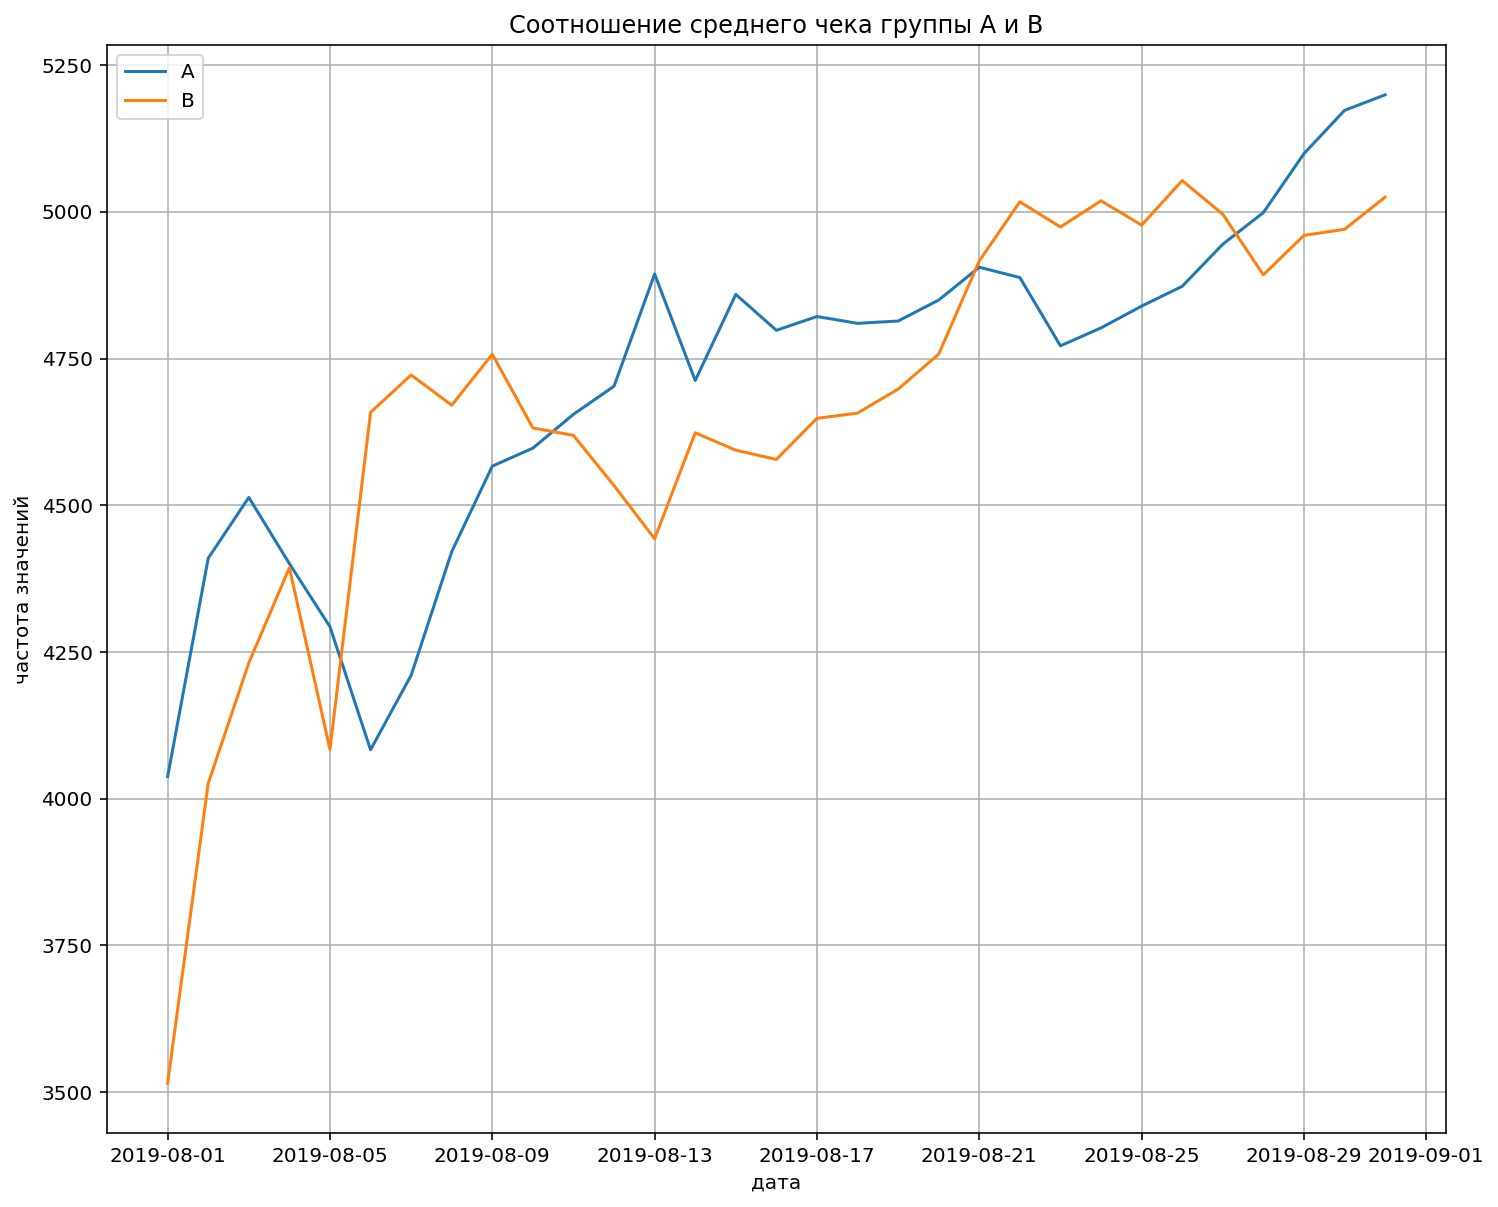

In [58]:
plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend() # разместим легенду на график
plt.title('Соотношение среднего чека группы А и В', fontsize = 12) # разместим название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

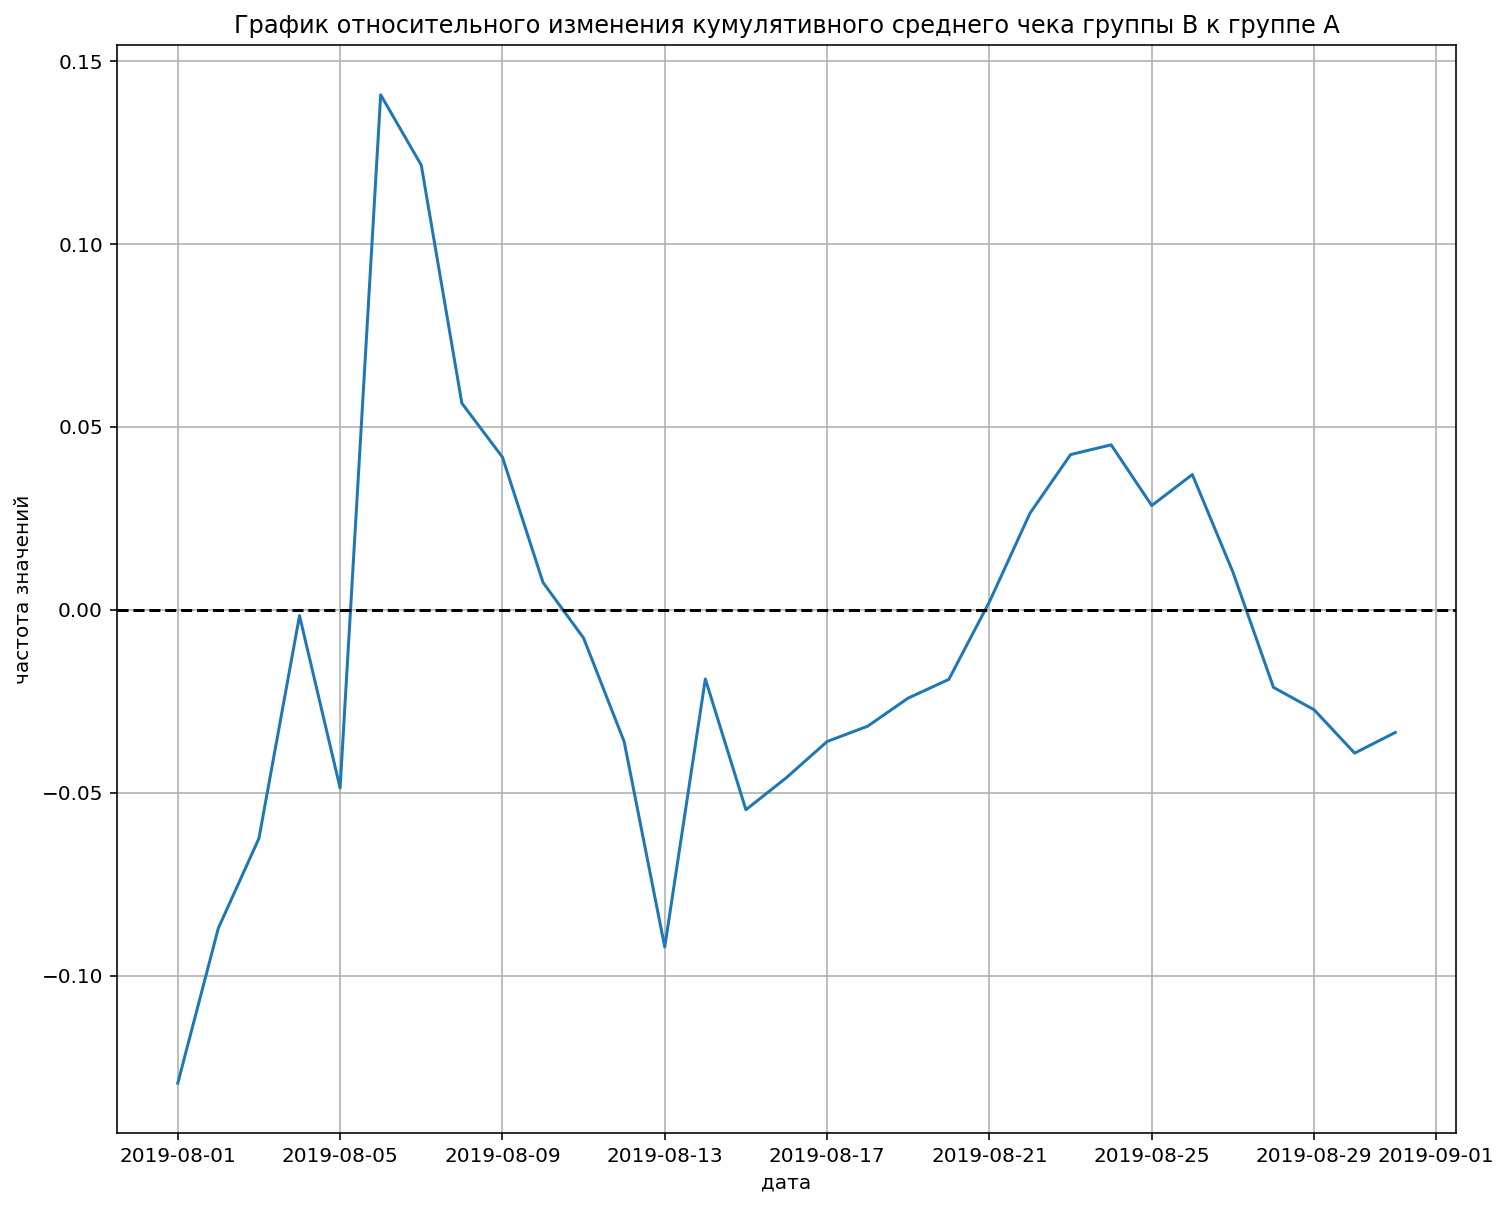

In [59]:
plt.figure(figsize=(12, 10)) # зададим размер сетки для графиков

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize = 12) # название графика
plt.xlabel('дата') # разместим название горизонатльной оси
plt.ylabel('частота значений') # разместим название вертикальной оси
plt.grid() # добавим сетку на график
plt.show(); # выведем график

**Вывод:** Как видно из графика относительного изменения кумулятивного среднего чека группы B к группе A по "очищенным" данным - результаты группы B хуже группы А, но еще не "устаканились". Если нам важен этот показатель, то тест следует продолжить.

Но учитывая, что снижение не значительное и что в графике относительного прирост конверсии группы B относительно группы A группа B стабильно и постепенно растёт с небольшими колебаниями, на конец теста - прирост 14%, тест можно остановить - зафиксировав победу группы В. 

## 5 Общий вывод.

В ходе выполнения проекты былы выполненны следующие работы: 
1. Проверили данные в таблице и привели их к нужно типу. 
2. Мы применили фреймворк для выбора наиболее подходящей гипотезы - `"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок."` Данная гипотеза будет иметь максимальный охват, повлияет на пользователей достаточно сильно, и задействует не много трудозатрат. 
3. Мы агрегировали данные для проведения А/Б теста. 
4. Построили графики кумулятивной выручки, среднего чека и относительно изминения конверсии. 
5. Выявили аномалии и исключили их по 95 процентилю. 
6. Подготовили выборки и посчитали статистичискую значимость изминений конверсии и размера среднего чека с аномалиями и без. 

По результатам проделанной работы можно сделать вывод:

- Что есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению.
- График различия среднего чека говорит о том, что результаты группы B лучше группы А на 25%: Но при отстутсвии анамалий мы видим незначительное снижение на 2%.
- Останавливаем тест, фиксируем победу группы B. После внедрения гипотезы конверсия увеличилась на 14%, средний чек изменился не значительно.